In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Load the dataset
data = pd.read_csv('survey lung cancer.csv')

In [5]:
data.duplicated().sum()

33

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data.shape

(276, 16)

In [8]:
# Label encoding the GENDER and LUNG_CANCER column
label_encoder = LabelEncoder()
data['LUNG_CANCER']=label_encoder.fit_transform(data['LUNG_CANCER'])
data['GENDER']=label_encoder.fit_transform(data['GENDER'])
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [9]:
# Feature selection
X = data[['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
          'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING',
          'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']]
y = data['LUNG_CANCER']


In [10]:
# Oversampling of Minority Class
from imblearn.over_sampling import RandomOverSampler
X_over,y_over=RandomOverSampler().fit_resample(X,y)

In [11]:
# Split the dataset
X_train,X_test,y_train,y_test = train_test_split(X_over,y_over,random_state=42,stratify=y_over)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (357, 15)
Test shape: (119, 15)


In [12]:
# Scaling of AGE column
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train['AGE']=scaler.fit_transform(X_train[['AGE']])
X_test['AGE']=scaler.transform(X_test[['AGE']])
X_train.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
321,0,-0.211324,2,1,1,1,1,2,1,1,1,1,2,1,1
336,0,0.998396,2,1,1,1,2,2,1,1,1,1,2,1,1
334,1,0.118600,2,1,1,2,1,1,1,1,1,2,2,1,1
151,0,0.228574,2,2,1,2,2,1,1,1,1,1,1,1,1
314,1,0.778447,2,1,1,1,1,1,2,2,2,2,1,1,2


In [13]:
# Convert categorical variables (like GENDER) to category type
X_train['GENDER'] = X_train['GENDER'].astype('category')
X_test['GENDER'] = X_test['GENDER'].astype('category')

# Convert the categories into numerical codes
X_train['GENDER'] = X_train['GENDER'].cat.codes
X_test['GENDER'] = X_test['GENDER'].cat.codes


In [14]:

# Define the parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],  # Step size shrinkage to prevent overfitting
    'n_estimators': [50, 75, 100, 150, 200, 300],  # Number of boosting rounds or trees
    'max_depth': [3, 5, 7, 9],  # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child node
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
    'subsample': [0.6, 0.8, 1.0],  # Subsampling ratio of the training data
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsampling ratio of columns when constructing each tree
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

# Use RandomizedSearchCV to search for the best hyperparameters
xgb_random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_grid, 
    n_iter=50,  # Number of random combinations to try
    cv=5,  # Cross-validation folds
    scoring='recall',  # Use recall as the metric for model selection
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Output progress
    random_state=42
)

# Fit the model to the training data
xgb_random_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_random_search.predict(X_test)

# Calculate confusion matrix
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


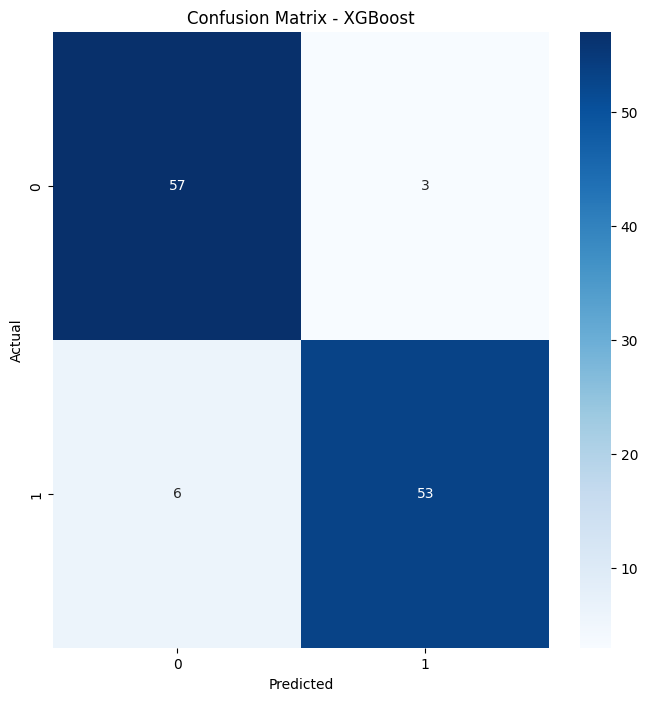

In [15]:
# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [16]:
# Print classification report
print(classification_report(y_test, y_pred_xgb))

# Output the best parameters
print(f'\nBest Parameters: {xgb_random_search.best_params_}\n')

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        60
           1       0.95      0.90      0.92        59

    accuracy                           0.92       119
   macro avg       0.93      0.92      0.92       119
weighted avg       0.93      0.92      0.92       119


Best Parameters: {'subsample': 1.0, 'n_estimators': 75, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.25, 'gamma': 0.1, 'colsample_bytree': 1.0}



In [17]:
# Save the trained model
with open('lung_cancer_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_random_search, file)
    
print("Model saved successfully!")


Model saved successfully!


In [18]:
# Initialize SVM model
svm_model = SVC(random_state=42)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Use GridSearchCV for hyperparameter tuning
svm_grid_search = GridSearchCV(
    svm_model, 
    param_grid_svm, 
    cv=5, 
    scoring='recall', 
    n_jobs=-1, 
    verbose=1
)

# Fit SVM model
svm_grid_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_grid_search.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [19]:
# Print classification report
print("\nSVM Model Report:")
print(classification_report(y_test, y_pred_svm))

# Output best parameters
print(f'\nBest Parameters for SVM: {svm_grid_search.best_params_}\n')


SVM Model Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77        60
           1       0.73      0.97      0.83        59

    accuracy                           0.81       119
   macro avg       0.84      0.81      0.80       119
weighted avg       0.84      0.81      0.80       119


Best Parameters for SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}



In [20]:
# Save the SVM model
with open('lung_cancer_svm_model.pkl', 'wb') as file:
    pickle.dump(svm_grid_search, file)
    
print("SVM Model saved successfully!")

SVM Model saved successfully!


              precision    recall  f1-score   support

           0       0.88      0.95      0.91        60
           1       0.94      0.86      0.90        59

    accuracy                           0.91       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.91      0.91      0.91       119



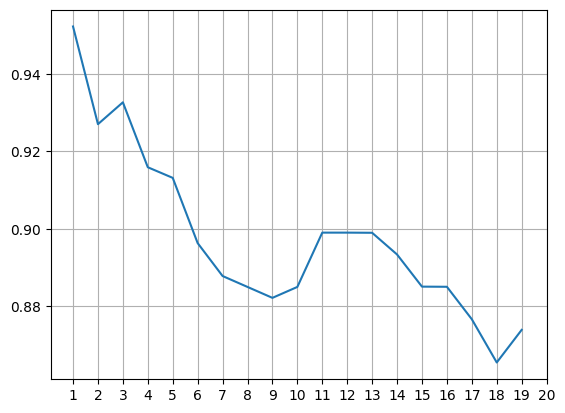

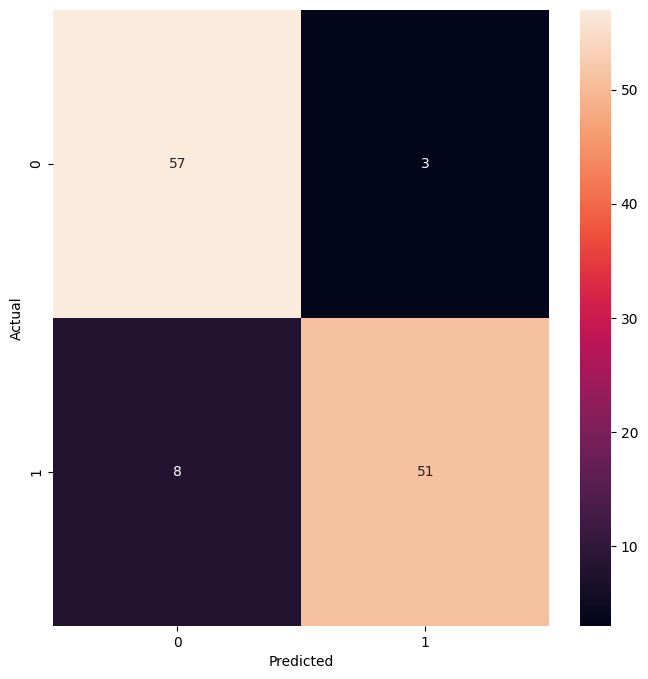

In [35]:
knn_scores=[]
for k in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train,y_train,cv=5)
    knn_scores.append(scores.mean())

x_ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
x_labels = x_ticks

plt.plot([k for k in range(1,20)],knn_scores)
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.grid()

knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
confusion_knn=confusion_matrix(y_test,knn.predict(X_test))
plt.figure(figsize=(8,8))
sns.heatmap(confusion_knn,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
from sklearn.metrics import classification_report
print(classification_report(y_test,knn.predict(X_test)))


# Save the trained KNN model
with open('lung_cancer_knn_model.pkl', 'wb') as file_knn:
    pickle.dump(knn_model, file_knn)